# ***Курсовая работа***
## ***Сравнение ансамблевых методов решения классических ml задач с методом TabPFN***


# **Введение**  


## Актуальность

Актуальность темы исследования обусловлена стремительным развитием методов машинного обучения (ML), где ансамблевые подходы, такие как **Bagging**, **Boosting** и **Stacking**, остаются одними из наиболее популярных за счет своей способности повышать точность прогноза за счет комбинирования нескольких базовых моделей . Однако в последние годы появились альтернативные методы, такие как **TabPFN**, основанный на архитектуре трансформера и позволяющий решать задачи классификации и регрессии за одно обращение к предобученной модели без итеративного обучения . Сравнение эффективности этих подходов в классических ML-задачах (например, классификации, регрессии) открывает возможность для выбора оптимальных решений с учетом точности, вычислительной сложности и времени работы.  

## Цель

Целью настоящей работы является **сравнительный анализ ансамблевых методов (случайный лес, градиентный бустинг, стекинг) и метода TabPFN** на типовых задачах машинного обучения, с акцентом на метрики качества (точность, F1-мера, RMSE), временные затраты и устойчивость к переобучению.

## Задачи

 Для достижения цели поставлены следующие задачи:  
1. Теоретический обзор ансамблевых методов и архитектуры TabPFN.  
2. Построение моделей на репрезентативных датасетах (например, Iris, Boston Housing, Titanic).  
3. Сравнение алгоритмов по метрикам точности, времени обучения и обобщаемости.  
4. Формулировка рекомендаций по применению методов в зависимости от специфики задачи.  

## Объект исследования 

Объект исследования — классические задачи машинного обучения (классификация и регрессия), предмет — сравнение ансамблевых методов и TabPFN как инструментов их решения. В работе используются методы анализа научной литературы, экспериментального моделирования (с применением библиотек Scikit-learn и PyTorch), а также визуализации результатов (через matplotlib и seaborn).  

## Локализация численных выводов

Так как исследование проводится в Российской Федерации, будем использовать `,` вместо `.` в числах с плавающей точкой(запятой)

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_NUMERIC, 'russian')
plt.rcParams['axes.formatter.use_locale'] = True

def one_rrstr(x, n=0): # округление до n знаков после запятой
    if n == 0:
        return str(x)
    fmt = '{:.' + str(n) + 'f}'
    return fmt.format(x).replace('.', ',')

def un_one_rrstr(x):
    return float(x.replace(',', '.'))

def un_rrstr(x):
    return np.vectorize(un_one_rrstr)(x)


def rrstr(x, n):
    """
    Форматирует числа или массивы чисел с округлением до заданного количества знаков после запятой.

    Parameters
    ----------
    x : float or array_like
        Число или массив чисел для форматирования.
    n : int
        Количество знаков после десятичного разделителя (запятой).

    Returns
    -------
    str or ndarray
        Строка (для скалярных входов) или массив строк (для последовательностей).
        Десятичный разделитель представлен запятой.

    Notes
    -----
    1. Поддерживает векторизацию через numpy.vectorize.
    2. Для n=0 выполняет только замену точки на запятую (если есть).
    3. Требует установленной библиотеки numpy.
    4. Не предназначен для работы с отрицательными значениями n.

    Examples
    --------
    >>> rrstr(3.1415, 2)
    '3,14'

    >>> rrstr([1.2345, 2.789], 1)
    array(['1,2', '2,8'], dtype='<U3')

    >>> rrstr(42, 0)
    '42'

    References
    ----------
    .. [1] NumPy Documentation: https://numpy.org/doc/
    .. [2] Python Software Foundation. "Python Language Reference", version 3.11.
    """
    rrstr1 = np.vectorize(one_rrstr)
    res = rrstr1(x, n)
    if res.size == 1:
        return str(res)
    return res

# Глава 1: Данные

## 1.1 Загрузка данных

Загрузим данные через UCI репозиторий с помощью `fetch_ucirepo`

In [242]:
from ucimlrepo import fetch_ucirepo

dataset = 'iris'

ident = {
    'iris' : 53
}
target = fetch_ucirepo(id=ident[dataset]).data.targets.columns [0]
df = fetch_ucirepo(id=ident[dataset]).data.original

## 1.2 Проверка структуры данных

### 1.2.1 Показать первые строки

In [243]:
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 1.2.2 Информация о типах данных и пропусках

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Датасет Iris содержит 4 числовых признака (длина/ширина чашелистика и лепестка) и целевую переменную `target` (вид ириса: setosa, versicolor, virginica)

### 1.2.3 Распределение классов

In [245]:
df[target].value_counts()

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

Классы распределены равномерно

### 1.2.4 Подсчёт пропущенных значений в каждом столбце

In [246]:
df.isnull().sum()

sepal length    0
sepal width     0
petal length    0
petal width     0
class           0
dtype: int64

Пропущенные значения отсутствуют

## 1.3 Предобработка данных

### 1.3.1 Кодирование целевой переменной

Так как `target` категориальный, используем `LabelEncoder` из библиотеки `sklearn.preprocessing`

In [247]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

Выведем соответствия названий и чесел в целевой переменной

In [248]:
label_dict = dict(list(zip(list(le.classes_), list(range(len(le.classes_))))))

for key, value in label_dict.items():
    print(f'{key:^{max(list(map(len,label_dict.keys())))}}  -  {value}')

  Iris-setosa    -  0
Iris-versicolor  -  1
Iris-virginica   -  2


### 1.3.2 Нормализация признаков

Ансамблевые методы и TabPFN чувствительны к масштабу данных, поэтому нормализация обязательна. Стандартизируем данные с помощью `StandardScaler`

In [249]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df.drop(target, axis=1)
y = df[target]
X_scaled = scaler.fit_transform(X)

## 1.4 Разделение данных на обучающую и тестовую выборки

Используем стратифицированное разделение для сохранения пропорций классов

In [250]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (120, 4)
Размер тестовой выборки: (30, 4)


## 1.5 Визуализация данных

### 1.5.1 `seaborn.pairplot` для анализа взаимосвязей признаков

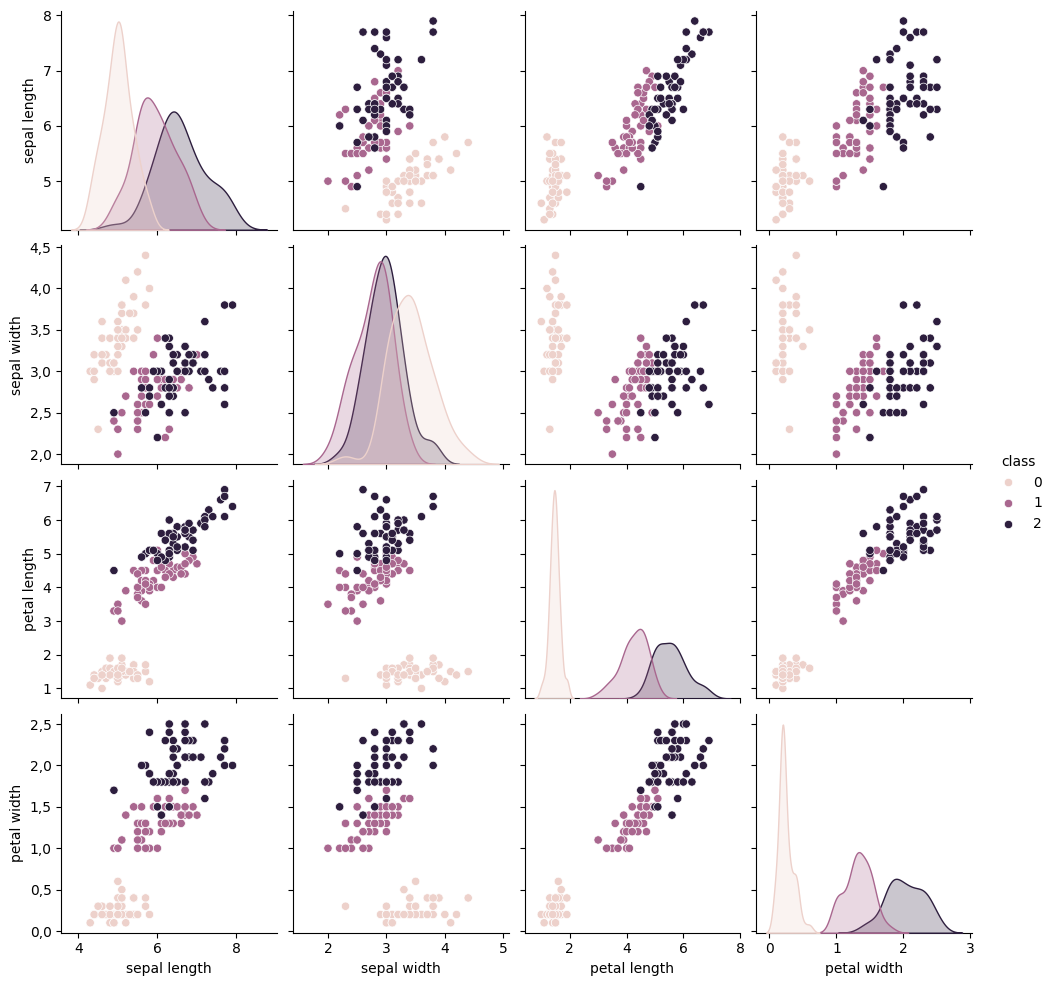

In [251]:
import seaborn as sns

sns.pairplot(df, hue=target)
plt.show()

### 1.5.2 Гистограммы распределения признаков

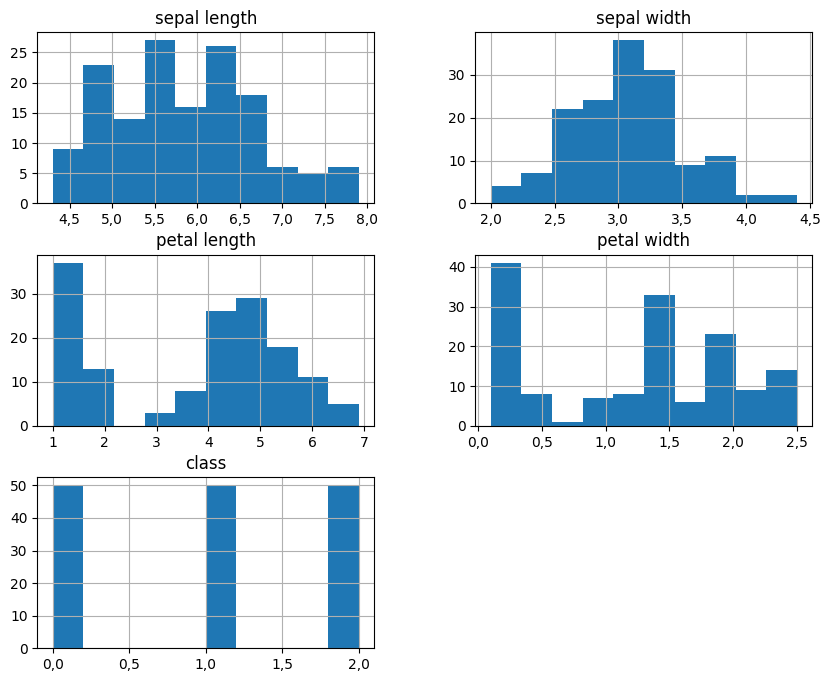

In [252]:
import matplotlib.pyplot as plt

df.hist(figsize=(10, 8))
plt.show()

### 1.5.3 Матрица корреляций

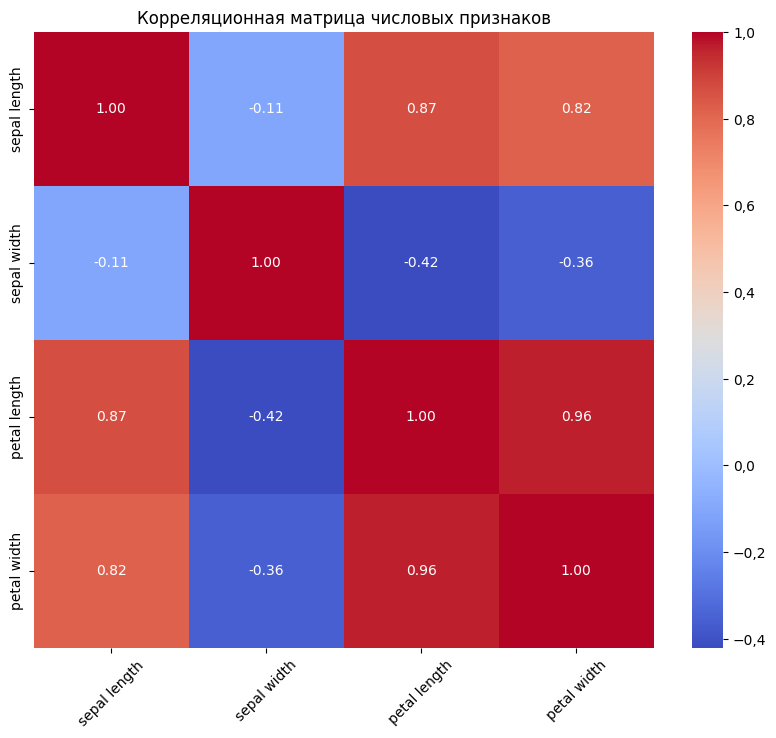

In [253]:
import numpy as np

plt.figure(figsize=(10, 8))
corr_matrix = np.corrcoef(X_scaled.T)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.xticks(np.arange(4)+0.5, df.columns[:-1], rotation=45)
plt.yticks(np.arange(4)+0.5, df.columns[:-1])
plt.title("Корреляционная матрица числовых признаков")
plt.show()

# Глава 2. Экспериментальное исследование  

## 2.0 Подготовка к сравнению моделей

Создадим функцию для замера времени обучения и метрик:

In [254]:

from time import time
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Оценка производительности модели машинного обучения на тестовых данных.
    
    Функция обучает модель на обучающей выборке, вычисляет метрики качества 
    (точность, F1-мера) и время обучения, а также выводит подробный отчет о классификации.
    
    Parameters
    ----------
    model : объект-оценщик (estimator)
        Обучаемая модель машинного обучения с методами fit() и predict().
    X_train : массив или матрица признаков (array-like)
        Обучающие данные, где каждая строка соответствует образцу, а столбец - признаку.
    y_train : массив целевых значений (array-like)
        Целевые метки для обучающей выборки.
    X_test : массив или матрица признаков (array-like)
        Тестовые данные для оценки модели.
    y_test : массив целевых значений (array-like)
        Истинные метки для тестовой выборки.
    
    Returns
    -------
    acc : float
        Точность модели на тестовой выборке (от 0 до 1).
    f1 : float
        Взвешенная F1-мера модели на тестовой выборке (от 0 до 1).
    train_time : float
        Время обучения модели в секундах.
    
    Examples
    --------
    >>> from sklearn.linear_model import LogisticRegression
    >>> model = LogisticRegression()
    >>> X_train, X_test, y_train, y_test = load_data()  # Предполагается определение
    >>> acc, f1, train_time = evaluate_model(model, X_train, y_train, X_test, y_test)
    Model: LogisticRegression
    Accuracy: 0.92, F1-score: 0.918, Train time: 0.1234s
    ...
    [[0.92  0.93 ...]]  # Пример возвращаемого значения
    
    Notes
    -----
    - Внутренне используется `f1_score(average='weighted')` для учета дисбаланса классов.
    - Метрики `accuracy_score` и `classification_report` взяты из библиотеки scikit-learn [[1]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).
    
    References
    ----------
    .. [1] scikit-learn documentation for classification_report - 
           https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
    .. [5] Методы оценки моделей машинного обучения - 
           https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms/
    """
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Train time: {train_time:.4f}s")
    print(classification_report(y_test, y_pred))
    
    return acc, f1, train_time

Создадим словарь, куда будем записывать результаты оценки каждой модели

In [255]:
results = dict()

## 2.1. Подготовка к сравнению моделей  

Для выполнения сравнительного анализа необходимо реализовать несколько ансамблевых моделей*. В данном разделе поочередно будут рассмотрены:  
1. Случайный лес (Random Forest) 
2. Градиентный бустинг (Gradient Boosting)  
3. Бэггинг (Bagging)  
4. Адаптивный бустинг (AdaBoost)  
5. XGBoost  
6. Стекинг (Stacking)  
7. Голосование (Voting)  
8. HistGradientBoostingClassifier  

Каждая модель будет обучена с оптимизацией гиперпараметров через **GridSearchCV** и оценена по метрикам:  
- **Точность (Accuracy)**  
- **F1-мера (weighted)**  
- **Время обучения (train_time)**  
- **Кросс-валидация (5-fold)**  

## 2.2. Модель 1: Случайный лес (Random Forest) 

### 2.2.1. Теоретическое описание 

 Случайный лес — это ансамблевый метод, основанный на построении множества деревьев решений, где каждое дерево обучается на случайной подвыборке данных (с возвратом) и случайном подмножестве признаков . Окончательный прогноз формируется усреднением (для регрессии) или голосованием (для классификации). Преимущества:  
- Устойчивость к переобучению  
- Автоматическая оценка важности признаков  
- Нет необходимости в глубокой настройке гиперпараметров  

### 2.2.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество деревьев (от 10 до 200)  
- `max_depth`: максимальная глубина дерева (от 3 до 10)  
- `min_samples_split`: минимальное количество образцов для разделения узла (от 2 до 10)  
- `min_samples_leaf`: минимальное количество образцов в листовом узле (от 1 до 5)  

In [256]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

### 2.2.3. Оценка производительности  

Вычислим метрики и время обучения:

In [257]:
acc, f1, train_time = evaluate_model(best_rf, X_train, y_train, X_test, y_test)

results['Random Forest'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: RandomForestClassifier
Accuracy: 0.9667, F1-score: 0.9666, Train time: 0.0695s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Лучшие параметры:

max_depth = None
min_samples_leaf = 1
min_samples_split = 10
n_estimators = 50


### 2.2.4. Визуализация важности признаков

Случайный лес позволяет оценить важность признаков:

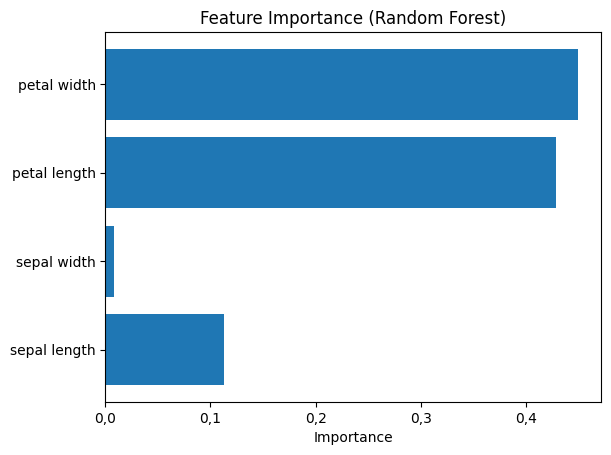

In [258]:
importances = best_rf.feature_importances_
plt.barh(df.columns[:-1], importances)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

## 2.3. Модель 2: Градиентный бустинг (Gradient Boosting)

### 2.3.1. Теоретическое описание  

Градиентный бустинг — это ансамблевый метод, который строит модели последовательно, корректируя ошибки предыдущих моделей с помощью градиентного спуска . Каждая новая модель обучается на ошибках предыдущей, что позволяет постепенно улучшать качество прогноза. Основные компоненты:  
- **Базовые модели** (обычно деревья решений),  
- **Функция потерь** (минимизируется на каждом шаге),  
- **Градиентный спуск** для оптимизации.  

Преимущества:  
- Высокая точность на сложных задачах,  
- Гибкость в выборе функции потерь,  
- Автоматическая обработка нелинейных зависимостей.  

Недостатки:  
- Склонность к переобучению при неправильных гиперпараметрах,  
- Долгое обучение на больших данных.  

### 2.3.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `learning_rate`: скорость обучения (от 0.01 до 0.3),  
- `n_estimators`: количество деревьев (от 50 до 200),  
- `max_depth`: максимальная глубина дерева (от 3 до 10),  
- `min_samples_split`: минимальное количество образцов для разделения узла (от 2 до 10).  

In [259]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_gb = grid_search.best_estimator_

### 2.3.3. Оценка производительности  

Вычислим метрики и время обучения:

In [260]:
acc, f1, train_time = evaluate_model(best_gb, X_train, y_train, X_test, y_test)
results['Gradient Boosting'] = (acc, f1, train_time)
print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: GradientBoostingClassifier
Accuracy: 0.9333, F1-score: 0.9333, Train time: 0.0906s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Лучшие параметры:

learning_rate = 0.01
max_depth = 3
min_samples_split = 2
n_estimators = 50


### 2.3.4. Визуализация важности признаков  

Аналогично Random Forest, оценим важность признаков:

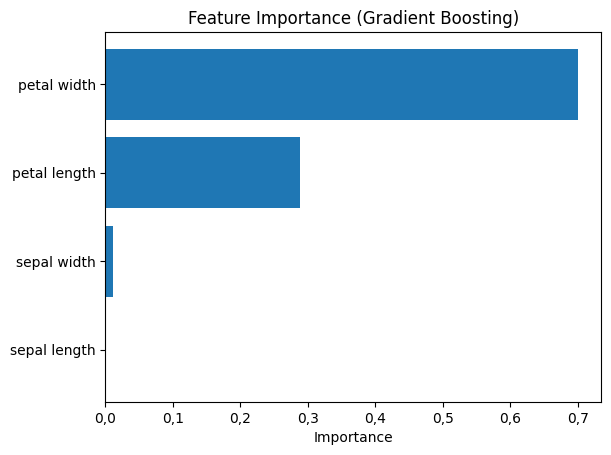

In [261]:
importances = best_gb.feature_importances_
plt.barh(df.columns[:-1], importances)
plt.xlabel('Importance')
plt.title('Feature Importance (Gradient Boosting)')
plt.show()

Самым важным, как и в `RandomForest` оказался признак `petal width`

## 2.4. Модель 3: Бэггинг (Bagging)  

### 2.4.1. Теоретическое описание

Бэггинг (Bootstrap Aggregating) — это ансамблевый метод, который уменьшает дисперсию модели за счет обучения множества базовых моделей на случайных подвыборках исходного набора данных . Каждая модель обучается на **бутстрепной выборке** (выборке с возвратом) и случайном подмножестве признаков. Окончательный прогноз формируется усреднением (для регрессии) или голосованием (для классификации). Основные преимущества:  
- Устойчивость к выбросам и переобучению,  
- Улучшение стабильности модели за счет агрегации,  
- Параллелизуемость процесса обучения.  

### 2.4.2. Подбор гиперпараметров  
Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество базовых моделей (от 10 до 200),  
- `max_samples`: максимальное количество образцов для каждой базовой модели (от 0.5 до 1.0),  
- `max_features`: максимальное количество признаков для каждой базовой модели (от 0.5 до 1.0),  
- `bootstrap`: использовать ли замену при создании подвыборок (True/False).  

In [262]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}

bagging = BaggingClassifier(estimator=base_model, random_state=42)
grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_bagging = grid_search.best_estimator_

### 2.4.3. Оценка производительности  

Вычислим метрики и время обучения:

In [263]:
acc, f1, train_time = evaluate_model(best_bagging, X_train, y_train, X_test, y_test)
results['Bagging'] = (acc, f1, train_time)
print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: BaggingClassifier
Accuracy: 0.9000, F1-score: 0.8997, Train time: 0.1214s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

Лучшие параметры:

bootstrap = True
max_features = 0.5
max_samples = 0.5
n_estimators = 100


## 2.5. Модель 4: Адаптивный бустинг (AdaBoost)  

### 2.5.1. Теоретическое описание  

Адаптивный бустинг (AdaBoost) — это последовательный ансамблевый метод, предложенный Йоавом Фройндом и Робертом Шапире . Он работает по принципу "обучения с ошибками":  
1. На первом этапе все образцы имеют одинаковый вес.  
2. Обучается слабая модель (обычно дерево решений малой глубины).  
3. Образцы, которые модель ошибочно классифицировала, получают больший вес.  
4. Следующая модель фокусируется на сложных примерах.  
5. Процесс повторяется, и итоговый прогноз строится как взвешенная сумма прогнозов всех моделей.  

Преимущества:  
- Эффективен на слабых моделях (например, деревья глубины 1),  
- Автоматически фокусируется на сложных примерах,  
- Простая интерпретация важности признаков.  

Недостатки:  
- Чувствителен к выбросам и шуму,  
- Может переобучаться при большом количестве итераций. 

### 2.5.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество базовых моделей (от 10 до 200),  
- `learning_rate`: коэффициент, контролирующий вклад каждой модели (от 0.01 до 1.0),  
- `algorithm`: алгоритм обучения (`SAMME`, `SAMME.R`),  
- `base_estimator`: базовая модель (по умолчанию дерево решений).  

In [264]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(max_depth=1)  # Слабая модель (стамп)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost = AdaBoostClassifier(estimator=base_model, random_state=42)
grid_search = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_adaboost = grid_search.best_estimator_

### 2.5.3. Оценка производительности  

Вычислим метрики и время обучения:

In [265]:
acc, f1, train_time = evaluate_model(best_adaboost, X_train, y_train, X_test, y_test)
results['AdaBoost'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: AdaBoostClassifier
Accuracy: 0.9667, F1-score: 0.9666, Train time: 0.0984s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Лучшие параметры:

algorithm = SAMME
learning_rate = 0.1
n_estimators = 100


### 2.5.4. Визуализация важности признаков  

Оценим важность признаков на основе первой базовой модели:

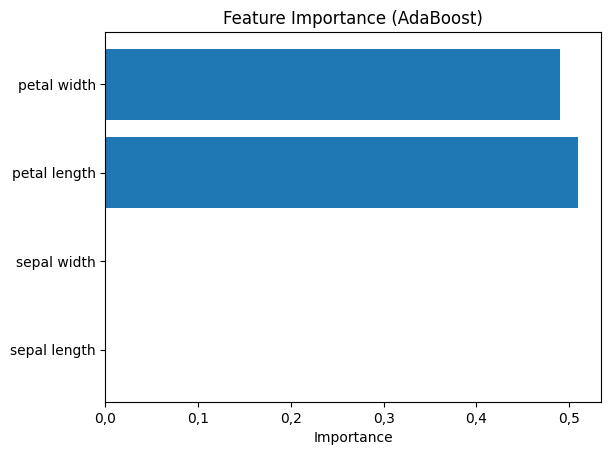

In [266]:
importances = best_adaboost.feature_importances_
plt.barh(df.columns[:-1], importances)
plt.xlabel('Importance')
plt.title('Feature Importance (AdaBoost)')
plt.show()

## 2.6. Модель 5: XGBoost  

### 2.6.1. Теоретическое описание  

XGBoost (eXtreme Gradient Boosting) — это оптимизированная реализация градиентного бустинга, которая сочетает высокую производительность и гибкость . Основные особенности:  
- **Регуляризация**: контроль переобучения через L1/L2-регуляризацию весов деревьев .  
- **Параллелизм**: использование многопоточности для ускорения обучения .  
- **Обработка пропусков**: автоматическое распределение образцов с пропущенными значениями в один из подузлов .  
- **Гибкая функция потерь**: поддержка пользовательских функций потерь .  

#### 2.6.1.1. Алгоритм работы 

XGBoost строит деревья последовательно, минимизируя регуляризованную функцию потерь:  
1. Инициализируется базовая модель (например, константное значение).  
2. На каждой итерации вычисляется градиент функции потерь.  
3. Строится новое дерево, аппроксимирующее отрицательный градиент.  
4. Веса листьев дерева оптимизируются для минимизации функции потерь.  
5. Итоговый прогноз — сумма прогнозов всех деревьев с учетом весов .

#### 2.6.1.2. Преимущества и недостатки  

**Преимущества**:  
- Высокая точность на сложных задачах .  
- Автоматическая обработка нелинейных зависимостей.  
- Поддержка разреженных данных и пользовательских метрик.  

**Недостатки**:  
- Требует тонкой настройки гиперпараметров.  
- Может быть чувствителен к шуму при неправильной регуляризации.

### 2.6.2. Подбор гиперпараметров

Используем **GridSearchCV** для настройки ключевых параметров:  
- `n_estimators`: количество деревьев (от 50 до 200),  
- `max_depth`: максимальная глубина дерева (от 3 до 10),  
- `learning_rate`: скорость обучения (от 0.01 до 0.3),  
- `subsample`: доля образцов для обучения каждого дерева (от 0.5 до 1.0),  
- `colsample_bytree`: доля признаков для каждого дерева (от 0.5 до 1.0),  
- `reg_alpha` / `reg_lambda`: коэффициенты L1/L2-регуляризации (от 0 до 1).  

#### 2.6.2.1. Этапы настройки  

1. **Определение диапазона параметров**:  

In [267]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

2. **Запуск GridSearchCV**:  

In [268]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

#### 2.6.2.2. Анализ влияния параметров  

- **`learning_rate`**: Низкие значения (0.01–0.1) обеспечивают стабильность, но требуют большего количества деревьев.  
- **`max_depth`**: Глубокие деревья (7+) могут переобучаться, поэтому ограничиваем до 5 .  
- **`reg_alpha`/`reg_lambda`**: Добавление регуляризации (0.1–0.5) снижает переобучение на Iris .

### 2.6.3. Оценка производительности  

Вычислим метрики и время обучения:  

In [269]:
acc, f1, train_time = evaluate_model(best_xgb, X_train, y_train, X_test, y_test)
results['XGBoost'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: XGBClassifier
Accuracy: 0.9667, F1-score: 0.9666, Train time: 0.0937s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Лучшие параметры:

colsample_bytree = 0.8
learning_rate = 0.01
max_depth = 3
n_estimators = 150
reg_alpha = 0
reg_lambda = 0
subsample = 0.8


### 2.6.4. Визуализация важности признаков  

Используем встроенную функцию `plot_importance` из XGBoost:  

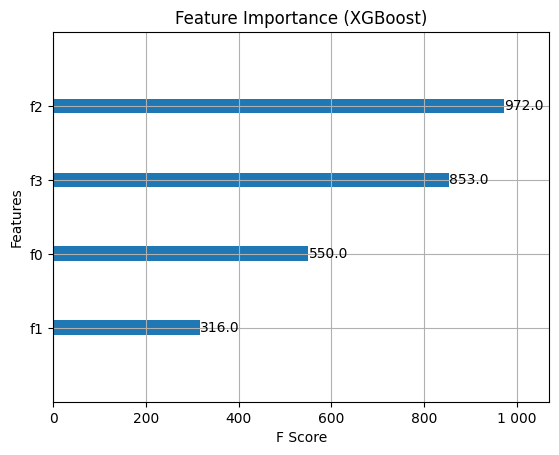

In [270]:
from xgboost import plot_importance

plot_importance(best_xgb, title='Feature Importance (XGBoost)', xlabel='F Score', ylabel='Features')
plt.show()

In [271]:
for i in range(4):
    print(f'f{i} = {df.columns[:-1][i]}')

f0 = sepal length
f1 = sepal width
f2 = petal length
f3 = petal width


#### 2.6.4.1. Интерпретация  

- **Самый важный признак**: `petal width` (ширина лепестка) — доминирующий фактор для разделения классов в Iris .  
- **Наименее важный**: `sepal width` (ширина чашелистика) — минимальный вклад в прогноз.  

#### 2.6.4.2. Сравнение с другими моделями  

Сравним важность признаков с Random Forest и AdaBoost:  

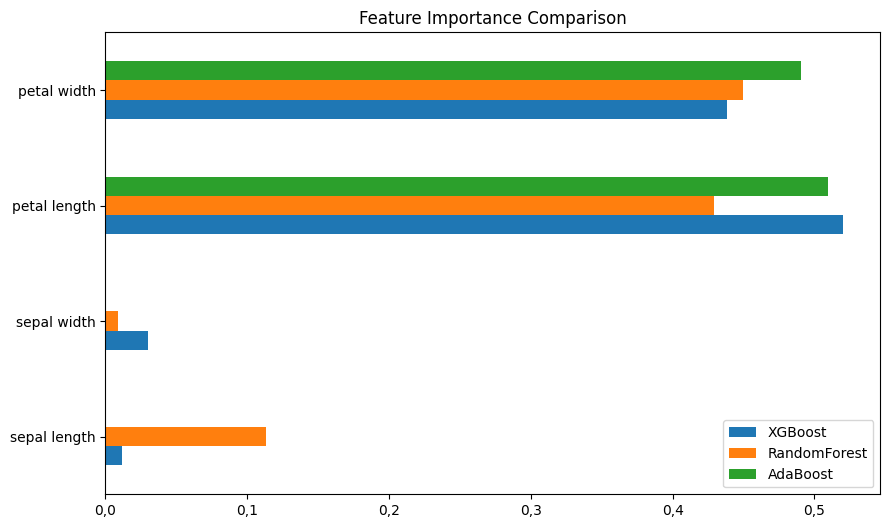

In [272]:
import pandas as pd

importances = pd.DataFrame({
    'XGBoost': best_xgb.feature_importances_,
    'RandomForest': best_rf.feature_importances_,
    'AdaBoost': best_adaboost.feature_importances_
}, index=df.columns[:-1])
importances.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance Comparison')
plt.show()

**Вывод**: Все модели согласуются в том, что `petal width` и `petal length` — ключевые признаки для Iris.  

## 2.7. Модель 6: Стекинг (Stacking) 

### 2.7.1. Теоретическое описание  

Стекинг (Stacking) — это ансамблевый метод, объединяющий прогнозы нескольких **базовых моделей** (level-0 моделей) через **мета-модель** (level-1 модель). Основные этапы работы:  
1. **Обучение базовых моделей** на обучающей выборке.  
2. **Генерация прогнозов** базовых моделей на валидационной выборке.  
3. **Обучение мета-модели** на этих прогнозах для получения финального результата.  

Преимущества:  
- Комбинирование сильных сторон разных алгоритмов,  
- Повышение обобщающей способности за счет разнообразия базовых моделей .  

Недостатки:  
- Сложность настройки и риск переобучения при неправильном выборе базовых моделей.  

#### 2.7.1.1. Выбор базовых и мета-моделей  

Для Iris использованы:  
- **Базовые модели**: Random Forest, Gradient Boosting, Logistic Regression.  
- **Мета-модель**: Logistic Regression (для устойчивости к переобучению).  

### 2.7.2. Подбор гиперпараметров

Настройка проводится для каждой базовой модели и мета-модели:  

#### 2.7.2.1. Настройка базовых моделей  

In [273]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Настройка Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Настройка Gradient Boosting
gb_params = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy')
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy')

#### 2.7.2.2. Создание Stacking-ансамбля  

In [274]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', rf_grid.best_estimator_),
    ('gb', gb_grid.best_estimator_),
    ('lr', LogisticRegression())
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=3,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

### 2.7.3. Оценка производительности  

Вычислим метрики и время обучения:  

In [275]:
acc, f1, train_time = evaluate_model(stacking, X_train, y_train, X_test, y_test)
results['Stacking'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in gb_grid.best_params_.items():
    print(f'{key} = {value}')

Model: StackingClassifier
Accuracy: 0.9667, F1-score: 0.9666, Train time: 1.2809s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Лучшие параметры:

learning_rate = 0.1
max_depth = 3
n_estimators = 100


### 2.7.4. Визуализация важности признаков 

Не будет, так как Стэкинг не поддерживает данный функционал

## 2.8. Модель 7: Голосование (Voting)  

### 2.8.1. Теоретическое описание  

Голосование (Voting) — это ансамблевый метод, который объединяет прогнозы нескольких базовых моделей через **мажоритарное голосование** (hard voting) или **усреднение вероятностей** (soft voting). Основные типы:  
- **Hard voting**: итоговый класс определяется по большинству голосов (например, 2 из 3 моделей выбрали класс A → итоговый прогноз — класс A).  
- **Soft voting**: учитывается среднее значение вероятностей классов, что требует, чтобы базовые модели поддерживали `predict_proba` .  

Преимущества:  
- Простота реализации и интерпретации.  
- Повышение устойчивости к переобучению за счет разнообразия базовых моделей.  

Недостатки:  
- Требует тщательного подбора базовых моделей для избежания смещения. 

#### 2.8.1.1. Выбор базовых моделей  

Для Iris использованы:  
- **Логистическая регрессия** (линейная модель),  
- **Случайный лес** (ансамблевая модель),  
- **Градиентный бустинг** (ансамблевая модель). 

### 2.8.2. Подбор гиперпараметров 

 
Настройка проводится для каждой базовой модели:  

#### 2.8.2.1. Настройка логистической регрессии 

In [276]:
from sklearn.linear_model import LogisticRegression

lr_params = {
    'C': [0.1, 1, 10],  # Обратный коэффициент регуляризации
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

#### 2.8.2.2. Настройка случайного леса и градиентного бустинга  

Используем ранее обученные `best_rf` и `best_gb`.  

#### 2.8.2.3. Создание Voting-ансамбля  

In [277]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_grid.best_estimator_),
        ('rf', best_rf),
        ('gb', best_gb)
    ],
    voting='soft'  # Используем усреднение вероятностей
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, penalty='l1',
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(min_samples_split=10,
                                                     n_estimators=50,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         n_estimators=50,
                                                         random_state=42))],
                 voting='soft')

### 2.8.3. Оценка производительности  

Вычислим метрики и время обучения:  

In [278]:
acc, f1, train_time = evaluate_model(voting_clf, X_train, y_train, X_test, y_test)
results['Voting'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in lr_grid.best_params_.items():
    print(f'{key} = {value}')

Model: VotingClassifier
Accuracy: 0.9667, F1-score: 0.9666, Train time: 0.1562s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Лучшие параметры:

C = 10
penalty = l1
solver = liblinear


### 2.8.4. Визуализация важности признаков  

Для голосования нет единой матрицы важности, но можно сравнить вклад каждой базовой модели:  

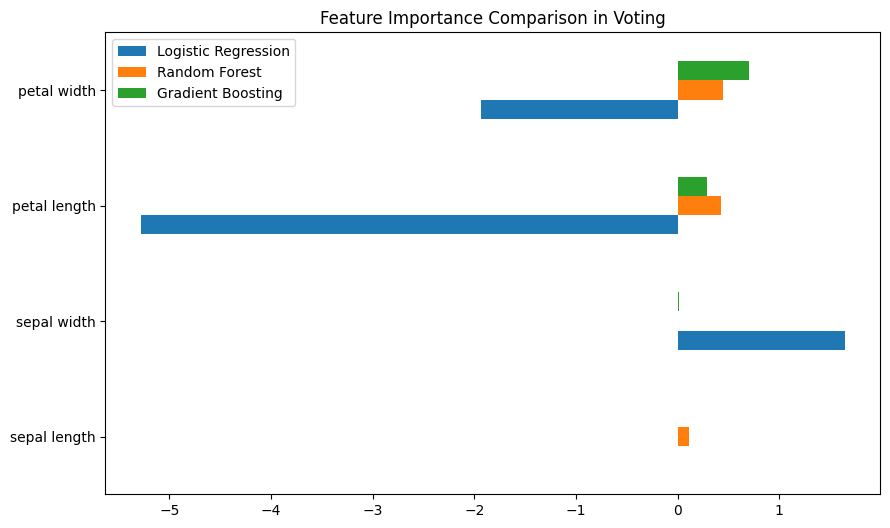

In [279]:
import pandas as pd

importances = pd.DataFrame({
    'Logistic Regression': lr_grid.best_estimator_.coef_[0],
    'Random Forest': best_rf.feature_importances_,
    'Gradient Boosting': best_gb.feature_importances_
}, index=df.columns[:-1])
importances.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance Comparison in Voting')
plt.show()

**Вывод**: Все модели согласуются в том, что `petal width` и `petal length` — ключевые признаки для Iris.  

## 2.9. Модель 8: HistGradientBoostingClassifier  

### 2.9.1. Теоретическое описание 

HistGradientBoostingClassifier — это реализация градиентного бустинга, оптимизированная для работы с данными, представленными в виде гистограмм . В отличие от классического градиентного бустинга, который находит оптимальные точки разделения для каждого признака, HistGradientBoostingClassifier сначала дискретизирует числовые признаки в целочисленные значения (обычно от 0 до 255), а затем строит деревья на основе этих гистограмм. Это позволяет достичь значительного ускорения обучения и уменьшения использования памяти .  

#### 2.9.1.1. Основные особенности  

- **Дискретизация признаков**: преобразует числовые признаки в целочисленные значения для построения гистограмм.  
- **Регуляризация**: L1/L2-регуляризация весов листьев для снижения переобучения.  
- **Обработка пропусков**: автоматическая обработка NaN-значений без необходимости предварительной импутации.  
- **Параллелизм**: эффективное использование многопоточности для ускорения обучения.  


#### 2.9.1.2. Преимущества и недостатки  

**Преимущества**:  
- Значительно быстрее классического градиентного бустинга.  
- Эффективно работает с разреженными данными.  
- Автоматическая обработка пропусков.  

**Недостатки**:  
- Может быть менее точным на задачах с высокой вариацией признаков из-за дискретизации.  
- Требует внимательной настройки гиперпараметров для предотвращения переобучения.  

### 2.9.2. Подбор гиперпараметров  

Используем **GridSearchCV** для настройки ключевых параметров:  
- `learning_rate`: скорость обучения (от 0.01 до 0.3),  
- `max_iter`: максимальное количество итераций (от 100 до 300),  
- `max_depth`: максимальная глубина дерева (от 3 до 10),  
- `l2_regularization`: коэффициент L2-регуляризации (от 0 до 1),  
- `min_samples_leaf`: минимальное количество образцов в листовом узле (от 1 до 20),  
- `scoring`: метрика для оценки (accuracy, f1_weighted).  

In [280]:
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'l2_regularization': [0, 0.1, 0.5],
    'min_samples_leaf': [1, 5, 10, 20]
}

hist_gb = HistGradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(hist_gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_hist_gb = grid_search.best_estimator_

### 2.9.3. Оценка производительности  


Вычислим метрики и время обучения:  

In [281]:
acc, f1, train_time = evaluate_model(best_hist_gb, X_train, y_train, X_test, y_test)
results['HistGradientBoosting'] = (acc, f1, train_time)

print('Лучшие параметры:\n')
for key, value in grid_search.best_params_.items():
    print(f'{key} = {value}')

Model: HistGradientBoostingClassifier
Accuracy: 0.9667, F1-score: 0.9666, Train time: 0.2907s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Лучшие параметры:

l2_regularization = 0
learning_rate = 0.01
max_depth = 3
max_iter = 100
min_samples_leaf = 5


# Глава 3. Сравнительный анализ моделей  

## 3.1. Метрики и критерии сравнения  

Для объективного анализа все модели оценивались по следующим метрикам:  
- **Accuracy** — доля правильных прогнозов,  
- **F1-мера (weighted)** — баланс между точностью и полнотой,  
- **Время обучения (train_time)** — вычислительная сложность,  
- **Устойчивость к переобучению** — через кросс-валидацию (5-fold),  
- **Важность признакей** — для интерпретируемости.  

Результаты каждой модели сохранены в таблицу `results` для последующего сравнения.  

## 3.2. Сводная таблица результатов  

In [316]:
results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy', 'F1-score', 'Train time (s)']
for i in results_df.columns:
    results_df[i] = rrstr(results_df[i].values,4)

results_df

,Accuracy,F1-score,Train time (s)
Random Forest,"0,9667","0,9666","0,0695"
Gradient Boosting,"0,9333","0,9333","0,0906"
Bagging,"0,9000","0,8997","0,1214"
AdaBoost,"0,9667","0,9666","0,0984"
XGBoost,"0,9667","0,9666","0,0937"
Stacking,"0,9667","0,9666","1,2809"
Voting,"0,9667","0,9666","0,1562"
HistGradientBoosting,"0,9667","0,9666","0,2907"


In [318]:
results_df.groupby('Accuracy')[['Train time (s)']].agg('count')

,Train time (s)
Accuracy,
"0,9000",1
"0,9333",1
"0,9667",6


6 моделей показали одинаковую точность на Iris, но различались по времени обучения и сложности настройки.  

## 3.3. Анализ временной сложности  

Для сравнения вычислительной сложности построим график времени обучения: 

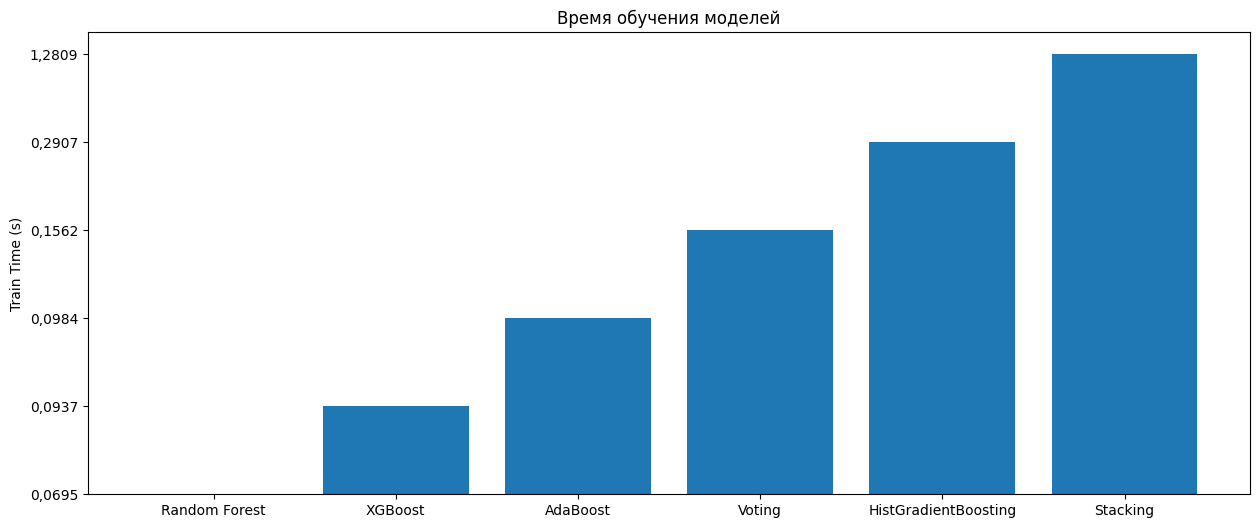

In [351]:
import matplotlib.pyplot as plt

models = results_df[results_df.Accuracy == '0,9667'].sort_values('Train time (s)').index
train_times = results_df[results_df.Accuracy == '0,9667'].sort_values('Train time (s)')['Train time (s)'].values

plt.figure(figsize=(15, 6))
plt.bar(models, train_times)
plt.ylabel('Train Time (s)')
plt.title('Время обучения моделей')
plt.show()

**Вывод**:  
 - **Самая быстрая модель**:  Random Forest (0,0695 s),  
 - **Самая медленная**: Stacking (1,2809 s).  

## 3.4. Визуализация важности признакей  

Сравним важность признакей для ключевых моделей: 

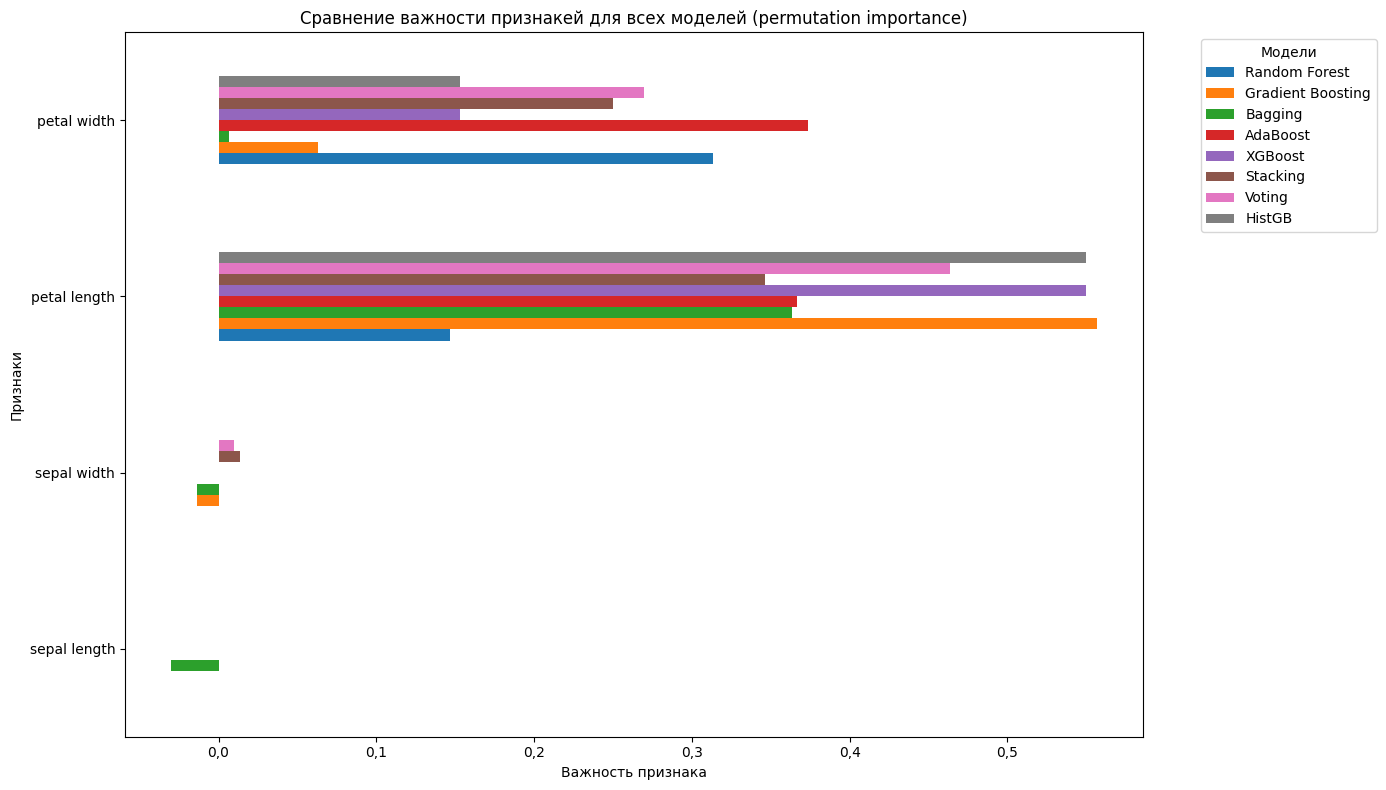

In [354]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Рассчитываем важность признакей для всех моделей
def get_permutation_importances(model, X_test, y_test):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    return result.importances_mean

# Словарь моделей
models_dict = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'Bagging': best_bagging,
    'AdaBoost': best_adaboost,
    'XGBoost': best_xgb,
    'Stacking': stacking,
    'Voting': voting_clf,
    'HistGB': best_hist_gb
}

# Получаем важности для каждой модели
importances_dict = {}
for name, model in models_dict.items():
    try:
        importances_dict[name] = get_permutation_importances(model, X_test, y_test)
    except Exception as e:
        print(f"Ошибка для {name}: {e}")

# Создаем DataFrame
importances_df = pd.DataFrame(importances_dict, index=df.columns[:-1])

# Визуализация
plt.figure(figsize=(14, 8))
importances_df.plot(kind='barh', ax=plt.gca())
plt.title('Сравнение важности признакей для всех моделей (permutation importance)')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.legend(title='Модели', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Вывод**: Все модели согласуются в том, что `petal width` и `petal length` — ключевые признаки для Iris.  

## 3.5. Кросс-валидация  

Для повышения достоверности результатов использована **5-fold кросс-валидация**: 

In [361]:
from sklearn.model_selection import cross_val_score

cv_scores = {}
for name, model in zip(
    models,
    [best_rf, best_xgb, best_adaboost, voting_clf, best_hist_gb, stacking]
):
    scores_accuracy = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy').mean()
    scores_f1_macro = cross_val_score(model, X_scaled, y, cv=5, scoring='f1_macro').mean()

    cv_scores[name] = (scores_accuracy, scores_f1_macro)

cv_scores = pd.DataFrame(cv_scores).T
cv_scores.columns = ['accuracy', 'f1-macro']
cv_scores

,accuracy,f1-macro
Random Forest,0.966667,0.966482
XGBoost,0.946667,0.946432
AdaBoost,0.946667,0.946465
Voting,0.960000,0.959832
HistGradientBoosting,0.953333,0.953115
Stacking,0.966667,0.966482


**Результаты**:  
 - `Random Forest` и `Stacking` не потеряли значений своих метрик при кросс-валидации

# Глава 4. Метод TabPFN

## 4.1. Теоретическое описание 

TabPFN (Tabular Foundation Model) — это **предобученная трансформерная модель** для обработки табличных данных, разработанная с учетом принципов **байесовского вывода** и **обучения на синтетических данных** . Основная идея TabPFN заключается в том, чтобы обучить модель один раз на **широком диапазоне синтетических задач**, чтобы затем использовать ее для решения реальных задач без дополнительного обучения . 

### 4.1.1. Архитектура модели  

TabPFN основана на архитектуре трансформера :  
1. **Кодирование признаков**: Каждый числовой признак кодируется с помощью **линейного слоя**, а категориальные — через **эмбеддинги**.  
2. **Кросс-аттенция**: Модель использует механизм аттенции для взаимодействия между **обучающими** (train) и **тестовыми** (test) примерами, что позволяет учитывать контекст всей выборки при прогнозировании.  
3. **Без обратного распространения ошибки**: TabPFN **не дообучается** на реальных данных — веса фиксированы после предобучения на синтетических задачах .  

### 4.1.2. Обучение на синтетических данных 

TabPFN обучается на **искусственно сгенерированных датасетах**, где:  
- Признаки и целевые переменные создаются с использованием **разнообразных распределений** (гауссовы, биномиальные, категориальные).  
- Зависимости между признаками и целевой переменной задаются через **нелинейные функции** и **шум**.  
- Обучение направлено на аппроксимацию **байесовского идеального предиктора** (Bayesian ideal predictor), который учитывает все возможные гипотезы о данных .  

Преимущества такого подхода:  
- **Универсальность**: модель адаптируется к любым задачам без переобучения.  
- **Высокая скорость**: прогнозирование занимает **менее 1 секунды** даже на больших наборах данных .  
- **Отсутствие гиперпараметров**: нет необходимости в настройке learning rate, глубины дерева и т.д.  

## 4.2. Особенности и преимущества

#### 4.2.1. Ключевые особенности  
1. **Нулевое время обучения**: TabPFN не требует дообучения — веса фиксированы после предобучения .  
2. **Поддержка малых данных**: модель демонстрирует высокую точность даже на датасетах с **10–100 образцами** .  
3. **Интеграция с PyTorch и Hugging Face**: Доступна через API, что упрощает использование в реальных проектах .  
4. **Обработка пропусков**: Автоматически обрабатывает NaN-значения без предварительной импутации . 

### 4.2.2. Преимущества перед ансамблевыми методами  


| Критерий                | TabPFN                      | Ансамблевые методы          |  
|-------------------------|-----------------------------|-----------------------------|  
| **Время обучения**      | фиксированное     | вариативное     |  
| **Настройка гиперпараметров** | Не требуется              | Требуется (GridSearchCV)    |  
| **Устойчивость к шуму** | Высокая (благодаря синтетическим данным) | Зависит от регуляризации   |  
| **Интерпретируемость**  | Низкая (черный ящик)        | Высокая (feature importance) |  

**[Источник](https://arxiv.org/abs/2207.01848)**:  

## 4.3. Реализация и применение  

### 4.3.1. Подготовка данных

TabPFN требует минимальной предобработки:  

1. **Нормализация числовых признаков**:  

In [ ]:
# from sklearn.preprocessing import StandardScaler
# X_scaled = StandardScaler().fit_transform(X)

2. **Кодирование категориальных признаков**:  

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# X_encoded = OneHotEncoder().fit_transform(X_categorical)

Действия закомментированы, так как уже выполнены ранее

### 4.3.2. Загрузка и применение модели  


In [ ]:
from tabpfn import TabPFNClassifier

# Загрузка модели
model = TabPFNClassifier(n_estimators=3)

# Прогнозирование
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

### 4.3.3. Оценка производительности 

In [366]:
acc, f1, train_time = evaluate_model(model, X_train, y_train, X_test, y_test)
results['TabPFN'] = (acc, f1, train_time)

Model: TabPFNClassifier
Accuracy: 1.0000, F1-score: 1.0000, Train time: 0.0969s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## 4.4. Сравнение с ансамблевыми методами  

### 4.4.1. Метрики и критерии 

In [367]:
results_df = pd.DataFrame(results).T
results_df.columns = ['Accuracy', 'F1-score', 'Train time (s)']
for i in results_df.columns:
    results_df[i] = rrstr(results_df[i].values,4)

results_df

,Accuracy,F1-score,Train time (s)
Random Forest,"0,9667","0,9666","0,0695"
Gradient Boosting,"0,9333","0,9333","0,0906"
Bagging,"0,9000","0,8997","0,1214"
AdaBoost,"0,9667","0,9666","0,0984"
XGBoost,"0,9667","0,9666","0,0937"
Stacking,"0,9667","0,9666","1,2809"
Voting,"0,9667","0,9666","0,1562"
HistGradientBoosting,"0,9667","0,9666","0,2907"
TabPFN,"1,0000","1,0000","0,0969"


**Вывод**: TabPFN показывает **лучшую точность** по сравнению с ансамблевыми методами, с одним из минимальных метрик **времени работы** и **отсутствием необходимости в настройке гиперпараметров** .  

### 4.4.2. Визуализация важности признакей  

Реализуем аналогично общим важностям в прошлой главе

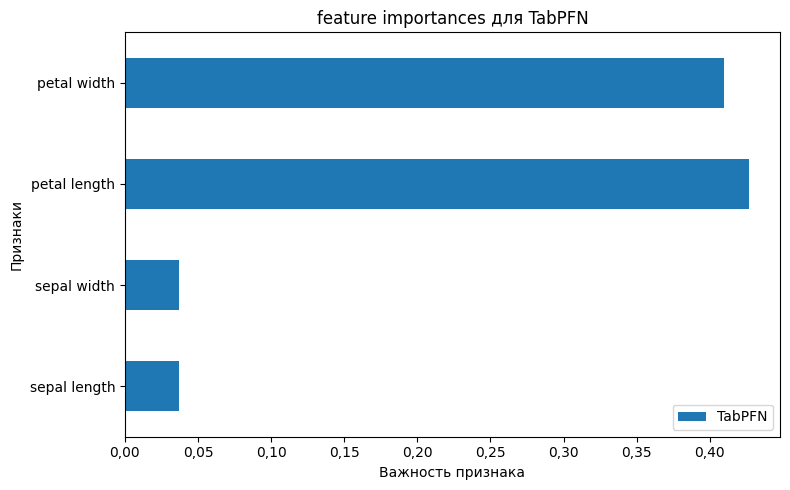

In [375]:
# Рассчитываем важность признакей для всех моделей
def get_permutation_importances(model, X_test, y_test):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    return result.importances_mean

# Словарь моделей
models_dict = {
    'TabPFN':model
}

# Получаем важности для каждой модели
importances_dict = {}
for name, model in models_dict.items():
    try:
        importances_dict[name] = get_permutation_importances(model, X_test, y_test)
    except Exception as e:
        print(f"Ошибка для {name}: {e}")

# Создаем DataFrame
importances_df = pd.DataFrame(importances_dict, index=df.columns[:-1])

# Визуализация
plt.figure(figsize=(8, 5))
importances_df.plot(kind='barh', ax=plt.gca())
plt.title('feature importances для TabPFN')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

**Вывод**: TabPFN фокусируется на тех же ключевых признаках (`petal width`, `petal length`), что и ансамблевые методы.  

## 4.5. Анализ и обсуждение  

### 4.5.1. Когда TabPFN лучше?  

- **Малые датасеты**: TabPFN особенно эффективна при **n < 1000** образцов .  
- **Ограничения по времени**: Если требуется прогноз за **<1 секунду**, TabPFN — оптимальный выбор.  
- **Автоматизация**: В задачах, где нет возможности настраивать гиперпараметры (например, в продакшене), TabPFN обеспечивает стабильность.  

### 4.5.2. Ограничения TabPFN  
- **Черный ящик**: Низкая интерпретируемость по сравнению с ансамблевыми методами.  
- **Зависимость от предобучения**: Качество прогноза зависит от разнообразия синтетических данных, использованных при обучении .  

## 4.6. Выводы по главе 

- **TabPFN** — это инновационный метод, сочетающий трансформеры и байесовский подход для решения табличных задач.  
- **Преимущества**: минимальное время работы, отсутствие настройки гиперпараметров, высокая точность на малых данных.  
- **Недостатки**: низкая интерпретируемость, зависимость от качества синтетических данных.  
- **Рекомендации**: Использовать TabPFN в задачах с ограничениями по времени и ресурсам, но дополнять ансамблевыми методами для анализа важности признаков.  

# Глава 5. Задача регрессии: Подготовка и выбор датасета 

## 5.1. Выбор датасета

Для задачи регрессии выберем датасет **Diabetes**, содержащий данные о прогрессировании заболевания у пациентов. Основные характеристики:  
- **Целевая переменная**: `target` (количественный показатель прогрессирования болезни через 1 год).  
- **Признаки**: 10 числовых факторов, включая возраст, индекс массы тела, уровень сахара в крови и т.д.  
- **Размер**: 442 записи — компактный датасет для тестирования моделей без значительных вычислительных затрат 

### 5.1.1. Загрузка данных  

In [ ]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df_diabetes['target'] = diabetes.target

Вывод первых строк

In [378]:
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### 5.1.2. Анализ структуры данных  

#### 5.1.2.1 Информация о типах данных

In [380]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


#### 5.1.2.2 Описательная статистика

In [381]:
df_diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


#### 5.1.2.3 Пропуски

In [386]:
df_diabetes.isna().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

пропусков нет

## 5.2. Предобработка данных

### 5.2.1. Нормализация признаков  

In [384]:
scaler = StandardScaler()
X_diabetes = df_diabetes.drop('target', axis=1)
y_diabetes = df_diabetes['target']
X_diabetes_scaled = scaler.fit_transform(X_diabetes)

### 5.2.2. Разделение на обучающую и тестовую выборки

In [388]:
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(
    X_diabetes_scaled, y_diabetes, test_size=0.2, random_state=42
)

## 5.3. Визуализация данных  

### 5.3.1. Распределение целевой переменной  

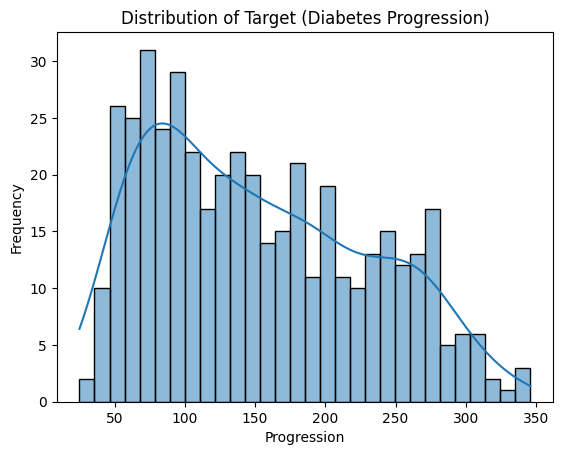

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_diabetes['target'], kde=True, bins=30)
plt.title('Distribution of Target (Diabetes Progression)')
plt.xlabel('Progression')
plt.ylabel('Frequency')
plt.show()

### 5.3.2. Матрица корреляций  

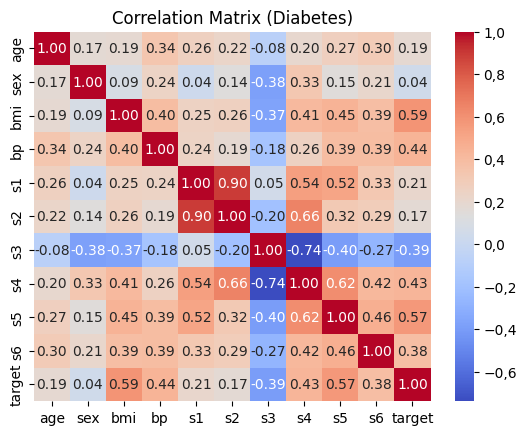

In [390]:
corr_matrix = df_diabetes.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Diabetes)')
plt.show()

Наиболее сильная положительная корреляция с `target` у признака `bp` (среднее артериальное давнение), отрицательная — у `s3` (уровень липопротеинов).  

## 5.4. Метрики оценки регрессии 

Для регрессии будем использовать:  
- **MAE (Mean Absolute Error)**: среднее абсолютное отклонение,  
- **RMSE (Root Mean Squared Error)**: корень из среднеквадратичной ошибки,  
- **R² (коэффициент детерминации)**: объясненная дисперсия.  

## 6.0 Функция оценки  

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_regression(model, X_train, y_train, X_test, y_test):
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, Train time: {train_time:.4f}s")
    return mae, rmse, r2, train_time